# Implements Rating Prediction Using Linear Regression

*Author*: Stella Zarei
*Created*: March 31st, 2025

### Import Util Functions

In [2]:
import os
import sys

# Import utils from subfolder of project, works for immediate subfolders of PROJECT_ROOT
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..')) # adjust relative import as necessary
sys.path.append(PROJECT_ROOT)
from utils.data_processing import get_filtered_review_data, get_metadata

### Import the Reviews and Metadata Datasets

In [3]:
# Fetch training, validation and test data
SELECTED_CATEGORY = 'Video_Games'
SELECTED_COLUMNS = ['user_id', 'product_id', 'parent_asin', 'title', 'text']

X_train, y_train, X_val, y_val, X_test, y_test = get_filtered_review_data(SELECTED_CATEGORY, include_columns=SELECTED_COLUMNS)
metadata = get_metadata(SELECTED_CATEGORY)

print("Metadata shape: " + str(metadata.shape))
print("Metadata columns: " + str(metadata.columns))

print("Training data shape: " + str(X_train.shape))
print("Training data columns: " + str(X_train.columns))

print("Validation data shape: " + str(X_val.shape))
print("Test data shape: " + str(X_test.shape))

Loading preprocessed data from data/Video_Games_min5_test1_val1_cols['user_id', 'product_id', 'parent_asin', 'title', 'text'].pkl
Loading metadata from data/Video_Games_metadata.pkl
Metadata shape: (137269, 11)
Metadata columns: Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'store', 'categories', 'details',
       'parent_asin'],
      dtype='object')
Training data shape: (625062, 5)
Training data columns: Index(['user_id', 'product_id', 'parent_asin', 'title', 'text'], dtype='object')
Validation data shape: (94762, 5)
Test data shape: (94762, 5)


### Import Product Embeddings from natural-language-processing Directory

In [4]:
# read metadata embeddings from file
import pickle
import pandas as pd
slice_list = []

for i in range(0, 5):
    with open (os.path.join(PROJECT_ROOT, 'natural-language-processing/description-embeddings', f'slice-{i}.pkl'), 'rb') as f:
        data = pickle.load(f)
        df = pd.DataFrame(data)
        slice_list.append(df)

# concatenate all slices
embedding_df = pd.concat(slice_list, ignore_index=True)

# modify index of embedding_df to match metadata['parent_asin']
embedding_df.index = metadata['parent_asin'].tolist()
embedding_df.index.name = 'parent_asin'

print(embedding_df.shape)
print(embedding_df.head())

(137269, 384)
                  0         1         2         3         4         5    \
parent_asin                                                               
B000FH0MHO  -0.005333  0.007172 -0.048593 -0.036893 -0.044139  0.030708   
B00069EVOG  -0.118838  0.048299 -0.002548 -0.011011  0.051951  0.010292   
B00Z9TLVK0  -0.035121  0.052389 -0.006503 -0.148511  0.003149 -0.006528   
B07SZJZV88  -0.118838  0.048299 -0.002548 -0.011011  0.051951  0.010292   
B002WH4ZJG  -0.080119 -0.035443 -0.041519 -0.050098  0.013094  0.065544   

                  6         7         8         9    ...       374       375  \
parent_asin                                          ...                       
B000FH0MHO   0.020790  0.124238 -0.079286  0.038286  ...  0.007196  0.022913   
B00069EVOG   0.115433  0.000701 -0.085925 -0.070654  ...  0.107304  0.011428   
B00Z9TLVK0  -0.022535 -0.038059  0.031254  0.096640  ...  0.135246 -0.000769   
B07SZJZV88   0.115433  0.000701 -0.085925 -0.070654  ...  0.

### Learn User Preferences Using Linear Regression

For each user $u_j$ find vector $\theta_j$ that best approximates the users preference <br><br>

$\theta_j$ that minimizes $$1/2 \sum_{x_i \in R(u_j)} ((\theta_j \cdot x_i) - y_{i,j})^2$$ 

Where $x_i$ is a product embedding<br>
$R(u_j)$ the set of products rated by $u_j$<br>
$y_{i,j}$ is the rating given to product $x_i$ by user $u_j$ <br>

### Uses Scikit Learn Ridge Model for Linear Regression
This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. 

In [5]:
import numpy as np
from sklearn.linear_model import Ridge

# user preferences described by theta and intercept
learned_preferences = {}

for user_id in X_train['user_id'].unique():
    # mask for current user
    user_mask = X_train['user_id'] == user_id
    product_rated_by_user = X_train[user_mask]['parent_asin'].tolist()
    rating_by_user = y_train[user_mask]

    # get the embeddings for 
    product_embeddings = [ embedding_df.loc[pid].values for pid in product_rated_by_user ]
    true_ratings = rating_by_user.tolist()

    # learn user preference
    model = Ridge()
    model.fit(product_embeddings, true_ratings)

    # store learned preference
    learned_preferences[user_id] = {'theta' : model.coef_, 'intercept' : model.intercept_}


### Use Learned Preference to Determine Training Error

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = []
y_pred = []

for row, rating in zip(X_train.itertuples(index=True), y_train.items()):
    user_id = row.user_id
    product_id = row.parent_asin
    _, actual_rating = rating

    if user_id not in learned_preferences:
        continue

    theta = learned_preferences[user_id]['theta']
    intercept = learned_preferences[user_id]['intercept']
    embedding = embedding_df.loc[product_id].values

    predicted_rating = np.dot(theta, embedding) + intercept
    predicted_rating = np.clip(predicted_rating, 0, 1)

    y_true.append(actual_rating)
    y_pred.append(predicted_rating)

# Metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

MSE: 0.0208, MAE: 0.0941


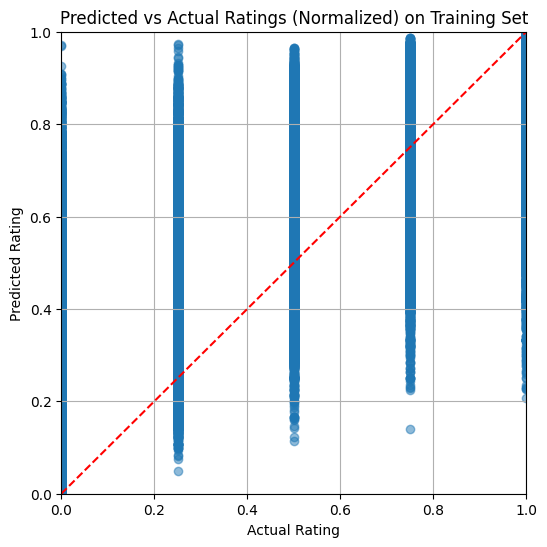

In [22]:
# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Predicted vs Actual Ratings (Normalized) on Training Set")
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

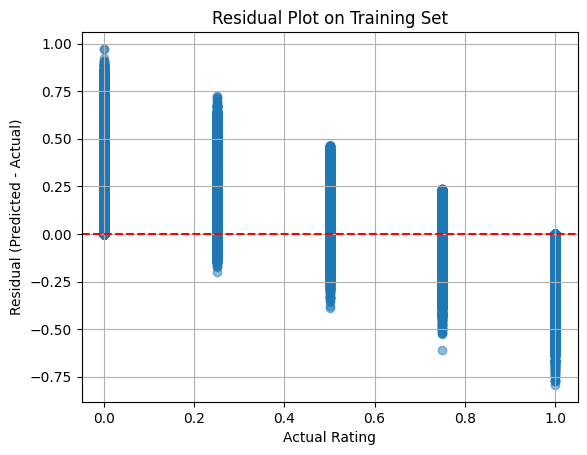

In [23]:
import matplotlib.pyplot as plt

residuals = np.array(y_pred) - np.array(y_true)

plt.scatter(y_true, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Rating")
plt.ylabel("Residual (Predicted - Actual)")
plt.title("Residual Plot on Training Set")
plt.grid(True)
plt.show()

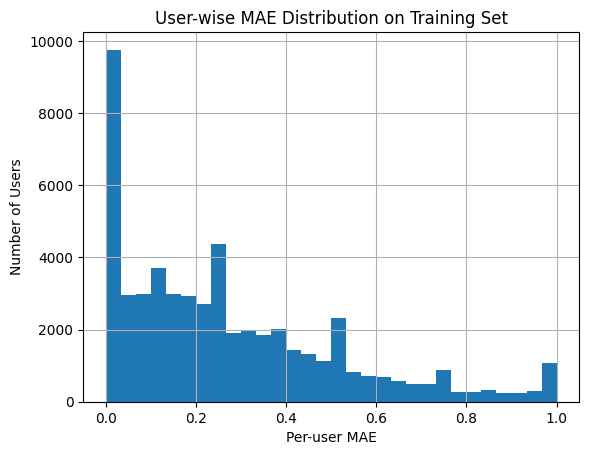

In [24]:
import pandas as pd

per_user_errors = {}

for row, (_, actual) in zip(X_train.itertuples(index=True), y_test.items()):
    user_id = row.user_id
    pid = row.parent_asin
    if user_id not in learned_preferences:
        continue
    theta = learned_preferences[user_id]['theta']
    intercept = learned_preferences[user_id]['intercept']
    pred = np.dot(theta, embedding_df.loc[pid].values) + intercept
    pred = np.clip(pred, 0, 1)
    error = abs(pred - actual)
    per_user_errors.setdefault(user_id, []).append(error)

# plot average per user
user_mae = {u: np.mean(errs) for u, errs in per_user_errors.items()}
pd.Series(user_mae).hist(bins=30)
plt.xlabel("Per-user MAE")
plt.ylabel("Number of Users")
plt.title("User-wise MAE Distribution on Training Set")
plt.grid(True)
plt.show()

### Use Learned Preferences to Determine Test Error

In [25]:
y_true = []
y_pred = []

for row, rating in zip(X_test.itertuples(index=True), y_test.items()):
    user_id = row.user_id
    product_id = row.parent_asin
    _, actual_rating = rating

    if user_id not in learned_preferences:
        continue

    theta = learned_preferences[user_id]['theta']
    intercept = learned_preferences[user_id]['intercept']
    embedding = embedding_df.loc[product_id].values

    predicted_rating = np.dot(theta, embedding) + intercept
    predicted_rating = np.clip(predicted_rating, 0, 1)

    y_true.append(actual_rating)
    y_pred.append(predicted_rating)

# Metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

MSE: 0.0984, MAE: 0.2066


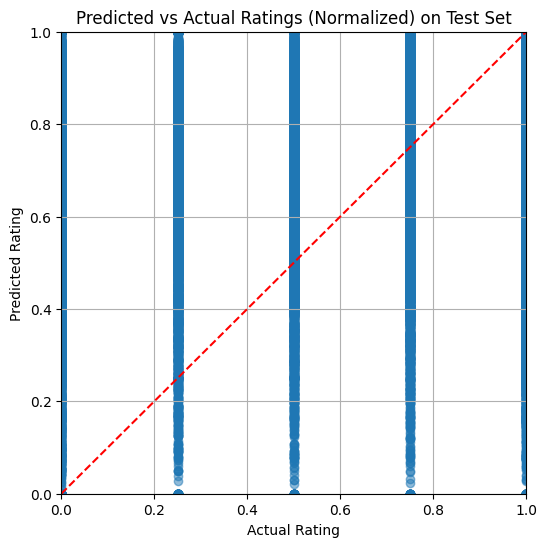

In [26]:
# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Predicted vs Actual Ratings (Normalized) on Test Set")
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

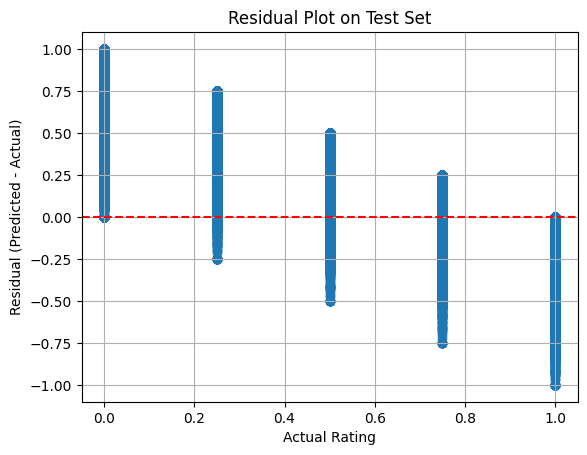

In [27]:
import matplotlib.pyplot as plt

residuals = np.array(y_pred) - np.array(y_true)

plt.scatter(y_true, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Rating")
plt.ylabel("Residual (Predicted - Actual)")
plt.title("Residual Plot on Test Set")
plt.grid(True)
plt.show()

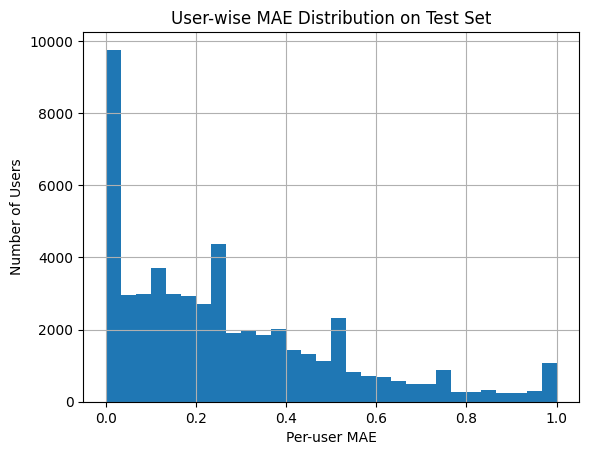

In [28]:
import pandas as pd

per_user_errors = {}

for row, (_, actual) in zip(X_train.itertuples(index=True), y_test.items()):
    user_id = row.user_id
    pid = row.parent_asin
    if user_id not in learned_preferences:
        continue
    theta = learned_preferences[user_id]['theta']
    intercept = learned_preferences[user_id]['intercept']
    pred = np.dot(theta, embedding_df.loc[pid].values) + intercept
    pred = np.clip(pred, 0, 1)
    error = abs(pred - actual)
    per_user_errors.setdefault(user_id, []).append(error)

# plot average per user
user_mae = {u: np.mean(errs) for u, errs in per_user_errors.items()}
pd.Series(user_mae).hist(bins=30)
plt.xlabel("Per-user MAE")
plt.ylabel("Number of Users")
plt.title("User-wise MAE Distribution on Test Set")
plt.grid(True)
plt.show()

### Get the Top Rated Products for a User

In [29]:
def get_top_rated_products(user_id, learned_preferences, embedding_df, X_train, N=10):
    if user_id not in learned_preferences:
        return []

    theta = learned_preferences[user_id]['theta']
    intercept = learned_preferences[user_id]['intercept']

    # Products the user has already rated (optional to exclude)
    seen_products = set(X_train[X_train['user_id'] == user_id]['parent_asin'])

    product_scores = []

    for pid in embedding_df.index:
        if pid in seen_products:
            continue  # skip products already rated

        embedding = embedding_df.loc[pid].values
        score = np.dot(theta, embedding) + intercept
        score = np.clip(score, 0, 1)  # normalized range
        product_scores.append((pid, score))

    # Sort by predicted score, descending
    top_products = sorted(product_scores, key=lambda x: -x[1])[:N]
    return top_products

In [ ]:
recommended_products = get_top_rated_products(4, learned_preferences, embedding_df, X_train, 20)

for pid, rating in recommended_products:
    print(f"{pid}\t{rating}")

B01N68V2ZX	0.9170889568071712
B000B6DTU6	0.9170889568071712
B087756SMP	0.9170889464068371
B07H3R1842	0.9170889464068371
B01F5Q2E3Y	0.9170889404012054
B0035J37BM	0.9170889404012054
B00069EVOG	0.9170889402161642
B07SZJZV88	0.9170889402161642
B07H93H878	0.9170889402161642
B09QXCZ6CX	0.9170889402161642
